# Markov Chains
A Markov chain model assumes that the change between match states does not depend on what has happened earlier, only on the current state. If the attacking team has the ball in midfield, the probability of it going into the box is the same, irrespective of whether the team has carried out a long sequence of passes, or if the ball has just arrived from a punt. This assumption oversimplifies aspects of football tactics, but it is a reasonable starting point.  Generally the window associated with ball movement is limited to about 10sec.

In this section expected threat will be determined in terms of a Markov chain.

In [1]:
import numpy as np

### Setting up the matrix
Set up the pass matrix A and the goal vector g.  The two arrays will represent the probability of the ball moving into anther area of the field (matrix A) and the likelihood of a goal from the associated position (vector g).  This will be used to solve for xT.

Table of probabilites:

|from/to|Mid|Box|Wing|Goal|
|---|---|---|---|---|
|Mid|25%|20%|10%|5%|
|Box|10%|25%|20%|15%|
|Wing|10%|10%|25%|5%|


In [2]:
# Pass matrix
A = np.matrix([[0.25, 0.20, 0.1], [0.1, 0.25, 0.2],[0.1, 0.1, 0.25]])
A

matrix([[0.25, 0.2 , 0.1 ],
        [0.1 , 0.25, 0.2 ],
        [0.1 , 0.1 , 0.25]])

In [3]:
# Goal vector
g = np.transpose(np.matrix([0.05, 0.15, 0.05]))
g

matrix([[0.05],
        [0.15],
        [0.05]])

### Linear algebra method
Solve the linear algerbra formula $(I-A)xT = g$ for xT.

In [4]:
xT1 = np.linalg.solve(np.identity(3) - A,g)

print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT1))

Expected Threat
Central, Box, Wing
[[0.14991763 0.25205931 0.12026359]]


### Iterative method
Iterate xT’ = A xT + g to update through each move of the ball.

In [5]:
xT2=np.zeros((3,1))
for t in range(10):
#    print(np.matmul(A,xT2) + g)
   xT2 = np.matmul(A,xT2) + g

In [6]:
print('Expected Threat')
print('Central, Box, Wing')
print(np.transpose(xT2))

Expected Threat
Central, Box, Wing
[[0.14966911 0.25182476 0.12007973]]


### Simulation method
Simulate num_sim possessions, starting from each of the three areas.  The simulation uses a random float generation to evaluate the 10 simulations and determine if a goal was scored.  The expected threat is then recalculated based on the number of goals ratio over the number of simulations conducted.  This will vary with each run through the code.  I provides an indication of how this might be evaluated manually.

Originally this was run at 10 simulations and it is quite vairable.  As you increase the simulations to 100, the values begin to coalesce at the same numbers in the prior solutions.

In [7]:
num_sims=100
xT3=np.zeros(3)

description = {0: 'Central', 1: 'Wing', 2: 'Box' }

for i in range(3):
    num_goals = 0

    print('---------------')
    print('Start from ' + description[i] )
    print('---------------')

    for n in range(num_sims):

        ballinplay=True
        #Initial state is i
        s = i
        describe_possession=''

        while ballinplay:
            r=np.random.rand()

            # Make commentary text
            describe_possession = describe_possession + ' - ' + description[s]


            #Cumulative sum of in play probabilities
            c_sum=np.cumsum(A[s,:])
            new_s = np.sum(r>c_sum)
            if new_s>2:
                #Ball is either goal or out of play
                ballinplay=False
                if r < g[s] + c_sum[0,2]:
                    #Its a goal!
                    num_goals = num_goals + 1
                    describe_possession = describe_possession + ' - Goal!'
                else:
                    describe_possession = describe_possession + ' - Out of play'
            s = new_s

        print(describe_possession)

    xT3[i] = num_goals/num_sims


print('\n\n---------------')
print('Expected Threat')
print('Central, Box, Wing')
print(xT3)

---------------
Start from Central
---------------
 - Central - Central - Central - Out of play
 - Central - Goal!
 - Central - Central - Out of play
 - Central - Box - Box - Box - Out of play
 - Central - Central - Central - Out of play
 - Central - Out of play
 - Central - Wing - Out of play
 - Central - Out of play
 - Central - Central - Central - Wing - Central - Out of play
 - Central - Wing - Box - Wing - Out of play
 - Central - Wing - Wing - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Box - Wing - Wing - Wing - Box - Out of play
 - Central - Wing - Central - Central - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Central - Out of play
 - Central - Out of play
 - Central - Goal!
 - Central - Wing - Central - Out of play
 - Central - Wing - Out of play
 - Central - Out of play
 - Central - Out of play
 - Central - Wing - Out of play
 - Central - Out of

# Calculated Expected Threat xT
Using a position based approach, expected threat, xT, will be determined for locations on the field.  This process was introduced to the world by Karun Singh in a blog post in 2018 [xT](https://karun.in/blog/expected-threat.html).  It was an extension of the work introduced by Sarah Rudd's Markov Model.

### Imports
Required imports, commenting out anything that has already been loaded in the notebook.

In [8]:
# importing necessary libraries
import pandas as pd
# import numpy as np # already loaded
import json
# plotting
import matplotlib.pyplot as plt
# opening data
import os
import pathlib
import warnings
# used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Opening data
Implement the Expected Threat model in the same way described by Karun Singh. First, extract the required event data to begin the assignment of values and iterate to a solution.  In this example, Wyscout data will be leveraged. 

In [9]:
#load data - store it in train dataframe
df = pd.DataFrame()
with open('./data/events_England.json') as f:
    data = json.load(f)
    df = pd.DataFrame(data)

In [10]:
df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173


### Actions moving the ball
Calculating Expected Threat can only occur for actions that move the ball. 
1. First filter passes from the database. 
2. Then remove passes that ended out of the pitch. 
3. To make the calculations easier create new columns with coordinates, one for each coordinate. 
4. Then, plot the location of actions moving the ball on 2D histogram. 

Note that dribbling is also an action that moves the ball. However, Wyscout does not store them in the v2 version that we are using in the course and not all ground attacking duels are dribblings. **In the end we store number of actions in each bin in a move_count array to calculate later move probability.**

In [16]:
next_event = df.shift(-1, fill_value=0)
move_df = (df
      .assign(nextEvent = next_event["subEventName"],
              kickedOut = lambda df: np.where(df.nextEvent == "Ball out of the field",1,0))
      .loc[lambda df: df.subEventName.isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
      .query('kickedOut == 0')
      .assign(x = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100),
              y = lambda df: df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100),
              end_x = lambda df: df.positions.apply(lambda cell: (cell[1]['x']) * 105/100),
              end_y = lambda df: df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100))
      .query('(end_x != 0 and end_y != 68) and (end_x != 105 and end_y != 0)')
          )

move_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,53.55,34.68,32.55,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,72.45,14.96,53.55,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,51.45,17.00,36.75,19.72


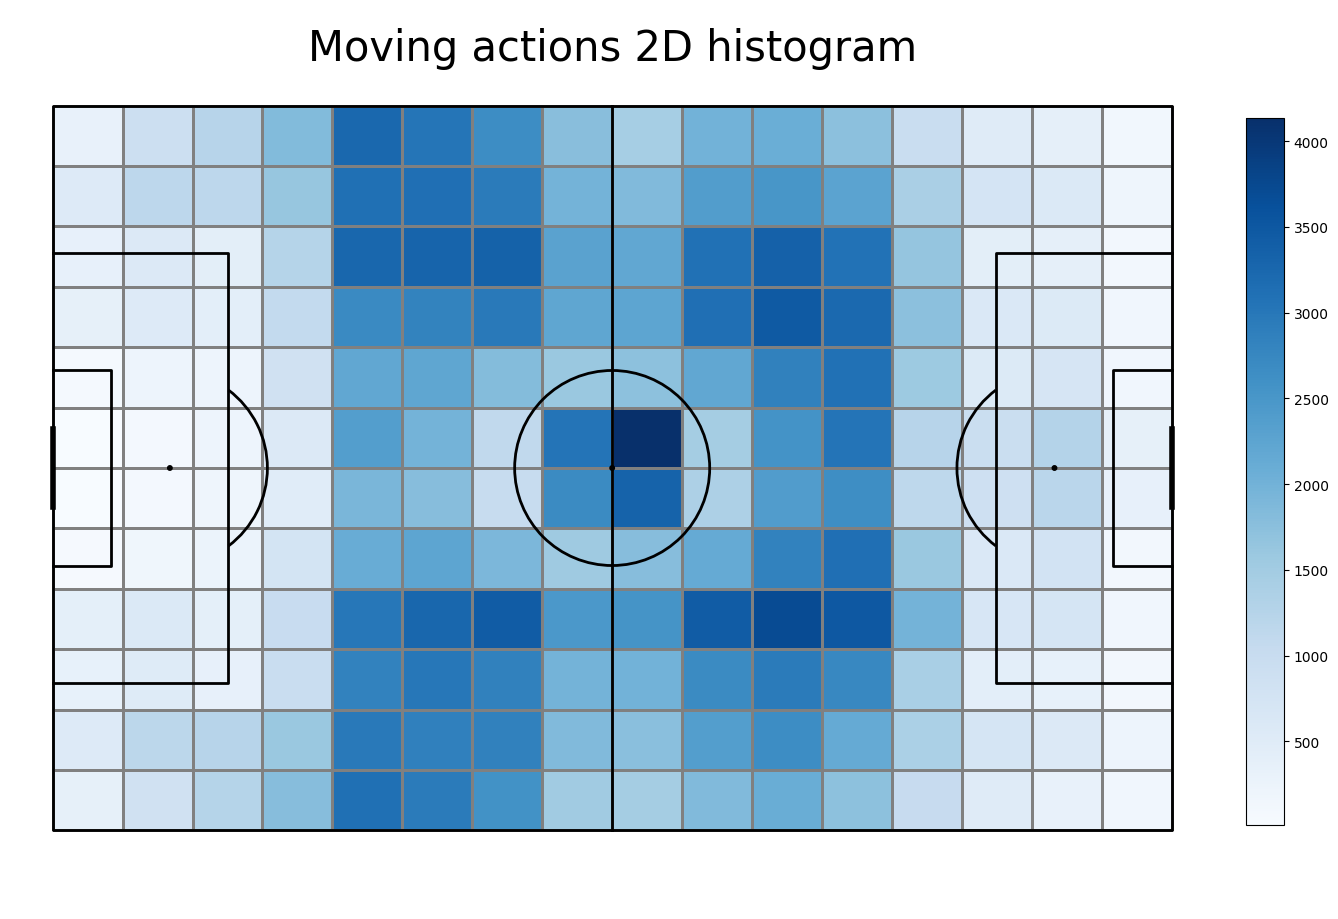

In [17]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]